# PEP 1 - Técnicas Computacionales para Radio Interferometría Astronómica

**Vicente Mieres**

**Instrucciones:**
- Prueba individual
- Responda en este notebook Jupyter
- Puede usar celdas markdown para explicaciones
- Tiempo: 90 minutos
- Puntaje total: 6.0 puntos + 1.0 punto base = 7.0 máximo

**Importaciones necesarias:**


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift
from scipy.ndimage import gaussian_filter
import astropy.coordinates as coord
from astropy import units as u
from astropy.time import Time
import warnings
import pandas as pd
from datetime import datetime, timedelta, timezone
import juliandate as jd
import matplotlib.dates as mdates
from scipy.spatial.distance import pdist
warnings.filterwarnings('ignore')

# Configuración de plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12


## Pregunta 1: Radio Astronomía General (1.5 puntos)

**Contexto:** Eres un astrónomo que debe diseñar un experimento para estudiar la emisión de radio de Júpiter (diámetro angular ~50 arcsec) y la Luna (diámetro angular ~30 arcmin) usando interferometría.

**Configuraciones disponibles:**
- **Arreglo A:** 8 antenas en línea, separación máxima 500m, frecuencia 74 MHz
- **Arreglo B:** 4 antenas en cuadrado, lado 1km, frecuencia 327 MHz
- **Arreglo C:** 6 antenas en Y, brazos de 2km, frecuencia 1.4 GHz

**1.1** (0.5 pts) Calcule la resolución angular máxima para cada arreglo usando θ ≈ λ/B_max.

**1.2** (0.5 pts) Determine cuál arreglo es más apropiado para cada objeto. Considere el tamaño angular y las frecuencias de emisión típicas.

**1.3** (0.5 pts) Si quisiera detectar estructuras de 1 arcsec en Júpiter, ¿qué configuración mínima necesitaría? ¿Qué limitaciones técnicas enfrentaría?


=== Pregunta 1.1 ===
Bmax A: 500.0
Resolución Angular A: 1672.41734794943
Bmax B: 1414.213562373095
Resolución Angular B: 133.80848001601026
Bmax C: 3464.1016151377553
Resolución Angular C: 12.759325865475757

=== Pregunta 1.2 ===
 Objeto Arreglo  Tamaño Obj. (")  Resolución Arr. (") Ratio (Tamaño/Res)            Veredicto          Ciencia Primaria
Júpiter       A               50             1672.417                0.0          No Resuelve Magnetósfera (Sincrotrón)
Júpiter       B               50              133.808                0.4          No Resuelve Magnetósfera (Sincrotrón)
Júpiter       C               50               12.759                3.9           Buen Mapeo       Atmósfera (Térmica)
   Luna       A             1800             1672.417                1.1      Apenas Resuelve           Débil (Térmica)
   Luna       B             1800              133.808               13.5           Buen Mapeo           Buena (Térmica)
   Luna       C             1800               12

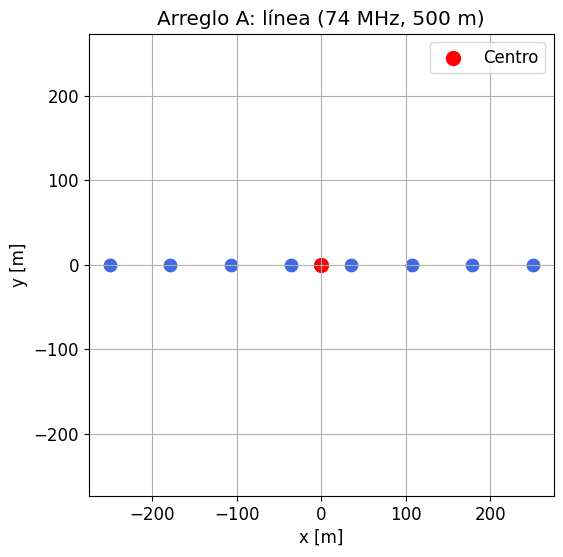

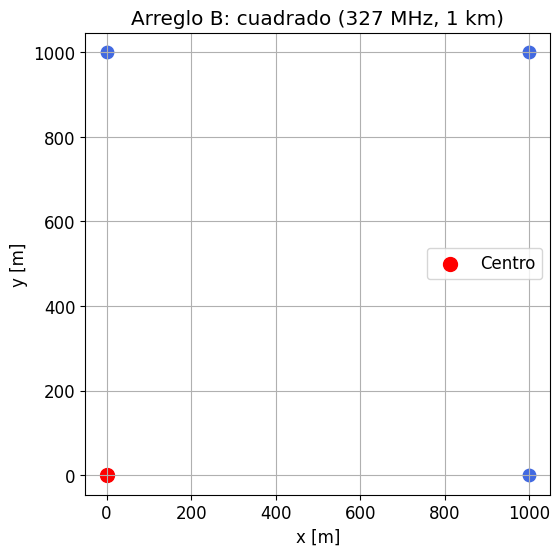

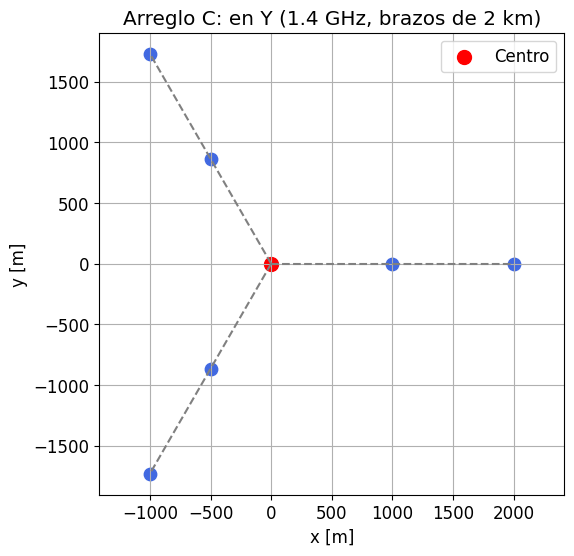

In [ ]:
# Su código aquí para Pregunta 1

# Funciones

def simular_arreglo(opcion="A"):
    """
    Funcion que simula los arreglos mencionado, creada con IA.
    Retorna tambien la Bmax
    """
    c = 3e8  # velocidad de la luz [m/s]
    arcsec_per_rad = 206265

    # -----------------------------
    # Configuraciones disponibles
    # -----------------------------
    if opcion.upper() == "A":
        freq = 74e6
        Bmax_nominal = 500
        N = 8
        # antenas en línea
        x = np.linspace(-Bmax_nominal/2, Bmax_nominal/2, N)
        y = np.zeros_like(x)
        nombre = "Arreglo A: línea (74 MHz, 500 m)"

    elif opcion.upper() == "B":
        freq = 327e6
        lado = 1000
        # 4 antenas en cuadrado
        x = np.array([0, lado, 0, lado])
        y = np.array([0, 0, lado, lado])
        nombre = "Arreglo B: cuadrado (327 MHz, 1 km)"

    elif opcion.upper() == "C":
        freq = 1.4e9
        L = 2000  # longitud de cada brazo [m]
        N_per_arm = 3  # antenas por brazo
        angles_deg = [0, 120, 240]  # Y típica

        coords = [(0, 0)]
        for ang in angles_deg:
            for i in range(1, N_per_arm):
                r = i * L / (N_per_arm - 1)
                coords.append((r*np.cos(np.radians(ang)), r*np.sin(np.radians(ang))))
        coords = np.array(coords)
        x, y = coords[:,0], coords[:,1]
        nombre = "Arreglo C: en Y (1.4 GHz, brazos de 2 km)"

    else:
        raise ValueError("Opción inválida. Usa 'A', 'B' o 'C'.")

    coords = np.column_stack((x, y))
    dist = pdist(coords)
    Bmax = np.max(dist)

    # -----------------------------
    # Gráfico
    # -----------------------------
    plt.figure(figsize=(6,6))
    plt.scatter(x, y, s=80, color="royalblue")
    plt.scatter(0, 0, color="red", s=100, label="Centro")
    plt.title(nombre)
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    plt.axis("equal")
    plt.grid(True)
    plt.legend()

    if opcion.upper() == "C":
        # dibuja líneas de los brazos
        for ang in [0, 120, 240]:
            plt.plot([0, L*np.cos(np.radians(ang))],
                     [0, L*np.sin(np.radians(ang))],
                     "gray", linestyle="--")

    return Bmax

def ang_res(freq, bmax, c):
    wavelength = c / freq
    res = wavelength / bmax
    res_arc = np.rad2deg(res) * 3600
    return res_arc

def analyze_array(arrays_data, objects_data):
    """
    Analyzes various telescope arrays to determine their suitability for observing specific astronomical objects.
    """
    results = []

    for obj_name, obj_params in objects_data.items():
        for arr_name, arr_params in arrays_data.items():
            # --- Extract data ---
            obj_size = obj_params['size_arcsec']
            arr_res = arr_params['resolucion_arcsec']
            arr_freq = arr_params['freq_mhz']

            # --- Perform analysis ---
            ratio = obj_size / arr_res

            # Resolution Veredict
            if arr_res > obj_size:
                veredicto = "No Resuelve"
            elif ratio < 3:
                veredicto = "Apenas Resuelve"
            elif ratio > 100:
                veredicto = "Riesgo Flujo Perdido"
            else:
                veredicto = "Buen Mapeo"

            # Science Case
            if obj_name == 'Júpiter':
                ciencia = "Magnetósfera (Sincrotrón)" if arr_freq < 1000 else "Atmósfera (Térmica)"
            else: # Luna
                ciencia = "Débil (Térmica)" if arr_freq < 200 else "Buena (Térmica)"

            # --- Store results ---
            results.append({
                "Objeto": obj_name,
                "Arreglo": arr_name,
                "Tamaño Obj. (\")": obj_size,
                "Resolución Arr. (\")": arr_res,
                "Ratio (Tamaño/Res)": f"{ratio:.1f}",
                "Veredicto": veredicto,
                "Ciencia Primaria": ciencia
            })

    return pd.DataFrame(results)

def calculate_required_frequency(b_max_m, theta_arcsec):
    """Calcula la frecuencia necesaria en GHz."""
    theta_rad = np.deg2rad(theta_arcsec / 3600.0)
    frequency_hz = c / (theta_rad * b_max_m)
    return frequency_hz / 1e9 # Convertir a GHz

def calculate_required_baseline(freq_hz, theta_arcsec):
    """Calcula la baseline necesaria en km."""
    wavelength = c / freq_hz
    theta_rad = np.deg2rad(theta_arcsec / 3600.0)
    baseline_m = wavelength / theta_rad
    return baseline_m / 1000 # Convertir a km


# Datos
c = 3e8

# configuraciones
bmaxA = simular_arreglo("A")
bmaxB = simular_arreglo("B")
bmaxC = simular_arreglo("C")

# 1.1 Calcular resolución angular máxima
print("=== Pregunta 1.1 ===")

resA = ang_res(freq=74e6, bmax=bmaxA, c=c)
print(f"Bmax A: {bmaxA}")
print(f"Resolución Angular A: {resA}")
resB = ang_res(freq=327e6, bmax=bmaxB, c=c)
print(f"Bmax B: {bmaxB}")
print(f"Resolución Angular B: {resB}")
resC = ang_res(freq=1.4e9, bmax=bmaxC, c=c)
print(f"Bmax C: {bmaxC}")
print(f"Resolución Angular C: {resC}")


# 1.2 Análisis de configuración apropiada
print("\n=== Pregunta 1.2 ===")

arrays_config = {
    'A': {'resolucion_arcsec': 1672.417, 'freq_mhz': 74},
    'B': {'resolucion_arcsec': 133.808,  'freq_mhz': 327},
    'C': {'resolucion_arcsec': 12.759,   'freq_mhz': 1400}
}
objects_config = {
    'Júpiter': {'size_arcsec': 50},
    'Luna': {'size_arcsec': 1800}
}


analysis_df = analyze_array(arrays_config, objects_config)
print(analysis_df.to_string(index=False))

# 1.3 Configuración para resolución de 1 arcsec
print("\n=== Pregunta 1.3 ===")

# Configuraciones del enunciado
arrays = {
    'A': {'freq_hz': 74e6,  'B_max_m': 500},
    'B': {'freq_hz': 327e6, 'B_max_m': np.sqrt(1000**2 + 1000**2)},
    'C': {'freq_hz': 1.4e9, 'B_max_m': 4000}
}

# Objetivo deseado
resolucion_deseada_arcsec = 1.0
# Constantes
c = 3e8  # Velocidad de la luz en m/s

print("="*65)
print(f"Análisis para alcanzar una resolución de {resolucion_deseada_arcsec:.0f} arcsec")
print("="*65)

print("\n### Análisis 1: Frecuencia Necesaria (con Baselines Fijas) ###\n")
print(f"{'Arreglo':<10} | {'Baseline Actual (m)':<20} | {'Frecuencia Necesaria (GHz)':<25}")
print("-" * 65)
for name, params in arrays.items():
    freq_req = calculate_required_frequency(params['B_max_m'], resolucion_deseada_arcsec)
    print(f"{name:<10} | {params['B_max_m']:<20.0f} | {freq_req:<25.1f}")

print("\n\n### Análisis 2: Baseline Necesaria (con Frecuencia Fija) ###\n")
print(f"{'Arreglo':<10} | {'Frecuencia Actual (MHz)':<22} | {'Baseline Necesaria (km)':<25}")
print("-" * 65)
for name, params in arrays.items():
    base_req = calculate_required_baseline(params['freq_hz'], resolucion_deseada_arcsec)
    print(f"{name:<10} | {params['freq_hz']/1e6:<22.1f} | {base_req:<25.0f}")
print("="*65)


frecuencia_hz = 22e9
baseline_necesaria_km = calculate_required_baseline(frecuencia_hz, resolucion_deseada_arcsec)
print(f"Análisis para alcanzar {resolucion_deseada_arcsec:.0f}\" de resolución a {frecuencia_hz / 1e9:.0f} GHz")
print("=" * 60)
print(f"\n📏 Baseline Máxima Requerida: {baseline_necesaria_km:.1f} km")

### Pregunta 1.1
Se pueden observar los resutados en la salida de la celda. Se agregaron plots de las configuraciones para visualizar mejor el arreglo.

### Pregunta 1.2
Para abordar esta pregunta, y determinar cual es el mejor arreglo para cada objeto se han considerado dos pasos principales.
- Paso 1 - Resolución y Ratio: En este se tomó el calculo de la resolución de la pregunta anterior para calcular el Ratio, y de esta forma determinar si la "imagen" puede ser tomada. De tal forma que un ratio menor a 1 implica que se descarta el arreglo, pues es incapaz de ver el objeto con algún detalle, caso contrario, se considera como arreglo viable.

- Paso 2 - Calidad de la imagen y frecuencia de emisión:
    - Calidad: Se utiliza el mismo ratio de antes para determinar si la imagen será buena. Un ratio muy bajo implicaría una imagen muy pobre, y uno muy alto podría advertir riesgo de *missing flux*.
    - Frecuencia de emisión: Se estudia que la frecuencia del arreglo se alinea con la física del objeto.

Tras esto, el arreglo C es adecuado para poder observar la emisión de Jupiter y estudiar la emisión térmica de este. En el caso de la Luna, el arreglo B es la elección óptima, y de la misma forma que el caso anterior pérmite estudiar emisión térmica.

### Pregunta 1.3
Como se puede observar en la salida de la celda anterior, se utilizaron los datos de los arreglos entregados para estudiar que frecuencia/baslines se necesitaría en caso de fijar uno, y observar un objetos de 1arcsec en Jupiter. Los resultados sugieren que ninguno de estos arreglos son fisicamente posibles. Sin embargo se plantea un ejemplo utilizando una frecuencia de 22GHz, el cual nos entrega un baseline necesario de 2.8km aproximadamente, lo cual se puede comparar con las capacidades del VLA, el cual posee una baseline maxima de 36km.

Algunas limitaciones técnicas que podemos considerar es la rotación de Jupiter, al ser tan rápida (10 horas) y requerir hartas horas de observación, las características a observar se desplazaríam. Otra limitación, relacionado tambien con la rotación, y es que al tomar un área tan pequeña como 1arcsec, la señal será muy débil y nuevamente se requerirían extendidos tiempos de observación.

## Pregunta 2: Coordenadas Espaciales (1.5 puntos)

**Contexto:** Ana es una astrónoma en Antofagasta, Chile (lat: -23.6°, lon: -70.4°) que planea observaciones durante el equinoccio de primavera (23 de septiembre). Quiere observar dos fuentes importantes:

- **Cygnus A (3C 405):** RA: 19h 59m 28.3s, Dec: +40° 44' 02.0"
- **Virgo A (M87):** RA: 12h 30m 49.4s, Dec: +12° 23' 28.0"

**2.1** (0.5 pts) Calcule las coordenadas horizontales de ambas fuentes a las 8:00 PM hora local del 23 de septiembre.

**2.2** (0.5 pts) Analice la visibilidad de ambas fuentes durante septiembre desde Antofagasta. ¿Cuál tiene mejor ventana de observación nocturna?

**2.3** (0.5 pts) Ana tiene restricciones de observación: elevación >20°, azimut entre 60° y 300°, y solo puede observar entre 6:00 PM y 6:00 AM. ¿Cuál fuente es más viable? Proponga un horario óptimo.



=== Pregunta 2.1 ===


Objeto Altura (°) Azimut (°) Visible (a > 0°) Visible (a > 20°)
0  CygnusA       0.12      44.52               Sí                No
1   VirgoA      33.57     304.82               Sí                Sí


📊 Resumen:
• Objetos sobre el horizonte (a > 0°): 2/2
• Objetos con buena elevación (a > 20°): 1/2

=== Pregunta 2.2 ===


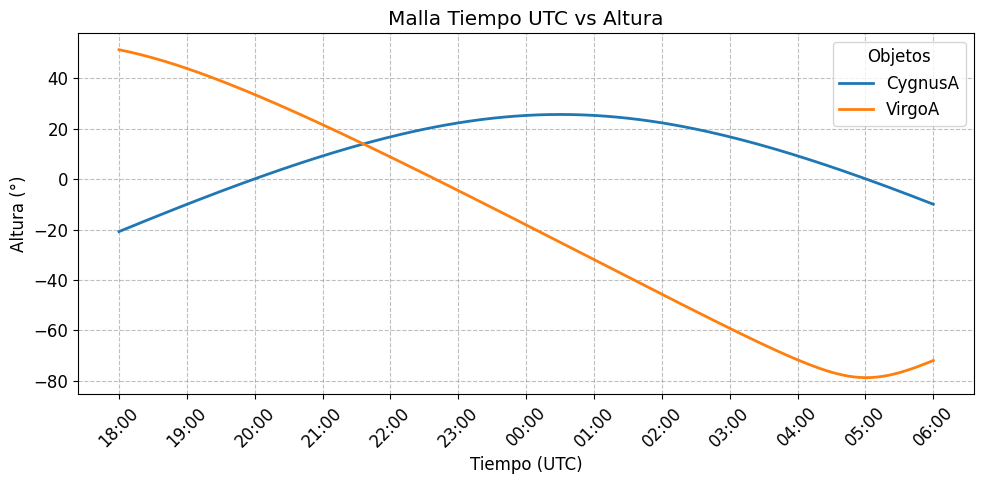


=== Pregunta 2.3 ===


Cuerpo      Salida (utc)    Tránsito (utc)      Puesta (utc)  \
0  CygnusA  2025-09-23 20:00  2025-09-24 00:30  2025-09-24 05:05   
1   VirgoA                NA  2025-09-23 18:00  2025-09-23 22:40   

  Ventana inicio (utc) Ventana fin (utc)  
0     2025-09-23 22:35  2025-09-24 02:25  
1     2025-09-23 20:30  2025-09-23 21:05

In [ ]:
# Su código aquí para Pregunta 2

# Datos de ubicación

catalog = {
        'CygnusA': {'RA': '19:59:28.3', 'Dec': '40:44:02.0'},
        'VirgoA': {'RA': '12:30:49.4', 'Dec': '12:23:28.0'},
    }

utc = "2025-09-23 20:00:00"
utc = datetime.fromisoformat(utc).replace(tzinfo=timezone.utc)

lat= -23.6 #phi
lon= -70.4 #lamnda

# Coordenadas de las fuentes (en grados)
# Cygnus A: RA: 19h 59m 28.3s, Dec: +40° 44' 02.0"
# Virgo A (M87): RA: 12h 30m 49.4s, Dec: +12° 23' 28.0"

# Funciones

def degree_to_time(theta, is_rad=False):
  """
  Converts degrees to hours, minutes and seconds.
  """
  if is_rad:
    theta = np.rad2deg(theta)

  h = int(theta/ 15)
  m = (int)(((theta / 15) - h) * 60)
  s = ((((theta / 15) - h) * 60) - m) * 60
  return h, m, s

def local_sidereal_time(longitude=-70.76, utc=None, single=True):
  """
  Calculates the local sidereal time in Radians.
  """
  if utc is None:
    now = datetime.now(timezone.utc)
  else:
    now = utc

  jd_now = jd.from_gregorian(now.year, now.month, now.day, now.hour, now.minute, now.second)
  T = (jd_now - 2451545.0) / 36525
  theta = 280.46061837 + 360.98564736629 * (jd_now - 2451545) + (0.000387933 * T * T) - (T * T * T / 38710000.0)
  deg = theta % 360 + longitude

  h,m,s = degree_to_time(deg)
  rad = np.deg2rad(deg)

  if single:
    return rad
  else:
    return deg, rad, h, m, s

def ra_dec_to_radians(radec, is_ra=True):
  """
  Converts right ascension and declination to Radians.
  """
  h, m, s = map(float, (radec.split(':')))

  value = abs(h) + m / 60 + s / 3600
  if is_ra:
    degrees = value * 15
  else:
    degrees = value if h >= 0 else -value
  return np.deg2rad(degrees)

def r_eq(alpha, delta):
  """
  Calculates the direction vector in equatorial coordinates.
  """
  ca, sa = np.cos(alpha), np.sin(alpha)
  cd, sd = np.cos(delta), np.sin(delta)
  return np.array([cd*ca, cd*sa, sd])

def Rz(theta):
  """
  Rotation matrix Z axis
  """
  c, s = np.cos(theta), np.sin(theta)
  return np.array([[ c, -s, 0],
  [ s, c, 0],
  [ 0, 0, 1]])

def Ry(theta):
  """
  Rotation matrix Y axis
  """
  c, s = np.cos(theta), np.sin(theta)
  return np.array([[ c, 0, s],
  [ 0, 1, 0],
  [-s, 0, c]])

def eq_to_hor(alpha, delta, phi, lst):
  """
  Transform equatorial coords into horizontal
  """
  v1 = Rz(-lst) @ r_eq(alpha, delta)
  v2 = Ry(phi) @ v1
  U = v2[0]
  E = v2[1]
  N = v2[2]
  a = np.arcsin(np.clip(U, -1.0, 1.0))
  Az = np.mod(np.arctan2(E, N), 2*np.pi)
  return a, Az

def eq_to_hor_validation(object_name=None, phi=-33.44, mode='single', utc=None):
    """
    Transform equatorial coords to horizontal and compares to a scalar method.
    """

    # Obtener LST
    lst_rad = local_sidereal_time(utc=utc, single=True)

    results_data = []

    for obj_name in catalog:
        # Parsing coordenadas
          ra = catalog[obj_name]['RA']
          dec = catalog[obj_name]['Dec']

          ra = ra_dec_to_radians(ra)
          dec = ra_dec_to_radians(dec, is_ra=False)

          # Transformación a horizontal
          a, A = eq_to_hor(alpha=ra, delta=dec, phi=np.deg2rad(phi), lst=lst_rad)

          # Convertir a grados
          a_deg = np.rad2deg(a)
          A_deg = np.rad2deg(A)

          # Determinar visibilidad
          visible = "Sí" if a_deg > 0 else "No"
          visible_30 = "Sí" if a_deg > 20 else "No"

          results_data.append({
              'Objeto': obj_name,
              'Altura (°)': f'{a_deg:.2f}',
              'Azimut (°)': f'{A_deg:.2f}',
              'Visible (a > 0°)': visible,
              'Visible (a > 20°)': visible_30
          })
    # Crear y mostrar tabla
    visibility_table = pd.DataFrame(results_data)
    display(visibility_table)

    # Resumen de objetos visibles
    visible_count = sum(1 for row in results_data if row['Visible (a > 0°)'] == 'Sí')
    visible_30_count = sum(1 for row in results_data if row['Visible (a > 20°)'] == 'Sí')

    print(f"\n📊 Resumen:")
    print(f"• Objetos sobre el horizonte (a > 0°): {visible_count}/2")
    print(f"• Objetos con buena elevación (a > 20°): {visible_30_count}/2")

    return visibility_table

def plot_altitudes(phi):

  altitudes = []
  times = []

  for obj in catalog:
    alt, t, As = get_altitudes(catalog[obj]['RA'], catalog[obj]['Dec'], phi=phi)
    altitudes.append(alt)
    times = t

  deg = np.linspace(-90, 90, 20)
  T, G = np.meshgrid(times, deg)

  # --- Graficar ---
  fig, ax = plt.subplots(figsize=(10,5))
  ax.set_title("Malla Tiempo UTC vs Altura")
  ax.set_xlabel("Tiempo (UTC)")
  ax.set_ylabel("Altura (°)")

  ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # cada hora
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=timezone.utc))

  ax.grid(True, which='major', linestyle='--', color='gray', alpha=0.5)

  for obj, alt in zip(catalog.keys(), altitudes):
      ax.plot(times, alt, lw=2, label=obj)

  ax.legend(title="Objetos", loc="best")

  # Mejorar eje X
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

  return altitudes, times, As

def get_altitudes(ra, dec, start='2025:09:23:18:00', end='2025:09:24:06:00', step_minutes=5, phi=-33.44):

  start = datetime.strptime(start, '%Y:%m:%d:%H:%M').replace(tzinfo=timezone.utc)
  end   = datetime.strptime(end, '%Y:%m:%d:%H:%M').replace(tzinfo=timezone.utc)
  total_minutes = int((end - start).total_seconds() / 60)
  offsets = np.arange(0, total_minutes + step_minutes, step_minutes)

  times = [start + timedelta(minutes=int(m)) for m in offsets]
  altitudes = []
  azimuts = []

  # h, m, s = ra.split(':')
  ra = ra_dec_to_radians(ra, is_ra=True)

  # h, m, s = dec.split(':')
  dec = ra_dec_to_radians(dec, is_ra=False)

  for t in times:
      lst_rad = local_sidereal_time(utc=t, single=True)
      a, A = eq_to_hor(alpha=ra, delta=dec, phi=np.deg2rad(phi), lst=lst_rad)
      altitudes.append(np.rad2deg(a))
      azimuts.append(np.rad2deg(A))

  return altitudes, times, azimuts

def get_rise_set(altitudes, times):
    """
    Calcula las horas de salida y puesta buscando cruces con 0°.
    Devuelve [hora_salida, hora_puesta] en string (UTC) o "NA" si no hay.
    """
    salida, puesta = None, None
    for i in range(1, len(altitudes)):
        if altitudes[i-1] < 0 and altitudes[i] >= 0:
            salida = times[i]
        if altitudes[i-1] >= 0 and altitudes[i] < 0:
            puesta = times[i]
    salida_str = salida.strftime("%Y-%m-%d %H:%M") if salida else "NA"
    puesta_str = puesta.strftime("%Y-%m-%d %H:%M") if puesta else "NA"
    return [salida_str, puesta_str]

def max_time(altitudes, times):
    """
    Retorna el instante y el índice en que la altitud es máxima.
    """
    max_idx = max(range(len(altitudes)), key=lambda i: altitudes[i])
    return times[max_idx], max_idx

def observation_window(altitudes, times, azimuths, threshold=20.0, min_duration=timedelta(minutes=0),az_min=0.0, az_max=360.0):
    """
    Encuentra intervalos donde altitud >= threshold. Y azimut se encuentre en un rango especifico.
    min_duration filtra ventanas muy cortas.
    Devuelve lista de tuplas (inicio, fin).
    """
    windows = []
    start_time = None

    for i in range(len(altitudes)):
        # Condición 1: La altitud es suficiente
        is_elevation_valid = altitudes[i] >= threshold
        # Condición 2: El azimut está en el rango correcto
        is_azimuth_valid = az_min <= azimuths[i] <= az_max

        # Si ambas condiciones son verdaderas, es un momento observable
        if is_elevation_valid and is_azimuth_valid:
            if start_time is None:
                # Inicia una nueva ventana de observación
                start_time = times[i]
        else:
            # Si las condiciones no se cumplen y había una ventana abierta, la cerramos
            if start_time is not None:
                end_time = times[i-1] # El último momento válido fue el anterior
                if end_time - start_time >= min_duration:
                    windows.append((start_time, end_time))
                # Reseteamos para buscar la siguiente ventana
                start_time = None

    # Caso especial: si el bucle termina mientras la ventana sigue abierta
    if start_time is not None:
        end_time = times[-1]
        if end_time - start_time >= min_duration:
            windows.append((start_time, end_time))

    return windows

def frame_rise_set(altitudes_list, times, az):
    """
    altitudes_list: lista de listas de altitudes (una por cada cuerpo)
    times: lista de datetime
    catalog: dict o lista con nombres de los objetos
    """
    results_data = []
    objs = list(catalog.keys()) if isinstance(catalog, dict) else list(catalog)

    for i, alt in enumerate(altitudes_list):
        # Salida / Puesta
        rise_set = get_rise_set(alt, times)

        # Tránsito
        max_dt, _ = max_time(alt, times)
        max_str = max_dt.strftime("%Y-%m-%d %H:%M")

        # Ventanas >30°
        windows = observation_window(alt, times, az,threshold=20, az_min=60, az_max=300)

        if windows:
            for w_start, w_end in windows:
                results_data.append({
                    "Cuerpo": objs[i],
                    "Salida (utc)": rise_set[0],
                    "Tránsito (utc)": max_str,
                    "Puesta (utc)": rise_set[1],
                    "Ventana inicio (utc)": w_start.strftime("%Y-%m-%d %H:%M"),
                    "Ventana fin (utc)": w_end.strftime("%Y-%m-%d %H:%M")
                })
        else:
            # fila sin ventanas
            results_data.append({
                "Cuerpo": objs[i],
                "Salida (utc)": rise_set[0],
                "Tránsito (utc)": max_str,
                "Puesta (utc)": rise_set[1],
                "Ventana inicio (utc)": "NA",
                "Ventana fin (utc)": "NA"
            })

    table = pd.DataFrame(results_data)
    display(table)
    return table

# Preguntas

# 2.1 Coordenadas horizontales a las 8:00 PM del 23 de septiembre
print("\n=== Pregunta 2.1 ===")

eq_to_hor_validation(utc=utc, phi=lat)

# 2.2 Análisis de visibilidad
print("\n=== Pregunta 2.2 ===")

alt, times, Az = plot_altitudes(phi=lat)

# 2.3 Restricciones de observación
print("\n=== Pregunta 2.3 ===")

t = frame_rise_set(alt, times, Az)


### Pregunta 2.1
Se pueden observar los resultados de cada objeto en la tabla presentada.

### Pregunta 2.2
Revisando el gráfico 'Malla Tiempo UTC vs Altura', podemos ver que CygnusA tiene una mejor ventan de observación nocturna, tal que es posible observarlo desde aproximadamente desde las 20PM hata las 5AM del día siguiente.

### Pregunta 2.3
Para las restricciones que presenta Ana, analizando la ultima tabla presentada anteriormente (con ventana considerada a 20grados y azimut [60, 300]), podemos ver que ambos poseen un un rango observable para Ana, sin embargo la ventana de CygnusA es, aproximadamente, 1 hora más larga, por lo tanto es más viables de observar. El rango horario recomendado es entre las 22:35PM del dia 23 hasta las 02:25AM del día 24.

## Pregunta 3: Muestreo UVW (1.5 puntos)

**Contexto:** Debes evaluar dos configuraciones de arreglo para el proyecto LOFAR-Chile. Cada configuración tiene 5 antenas:

**Configuración A (L):** Antenas en forma de L con brazos de 100m y 200m
**Configuración B (Estrella):** Antenas en forma de estrella de 5 puntas con radio de 150m

**3.1** (0.5 pts) Calcule todas las baselines para ambas configuraciones.

**3.2** (0.5 pts) Para observaciones a 150 MHz, calcule las coordenadas uvw para ambas configuraciones asumiendo que apuntan al cenit.

**3.3** (0.5 pts) Analice la cobertura uv de ambas configuraciones. ¿Cuál recomienda para observar una nebulosa planetaria de 30 arcsec? Justifique considerando resolución y sensibilidad a estructuras extendidas.



=== Pregunta 3.1 ===
Número de Baselines configuracion A: 10
Número de Baselines configuracion B: 10

=== Pregunta 3.2 ===
UVW_A:  (20, 3)
UVW_B:  (20, 3)


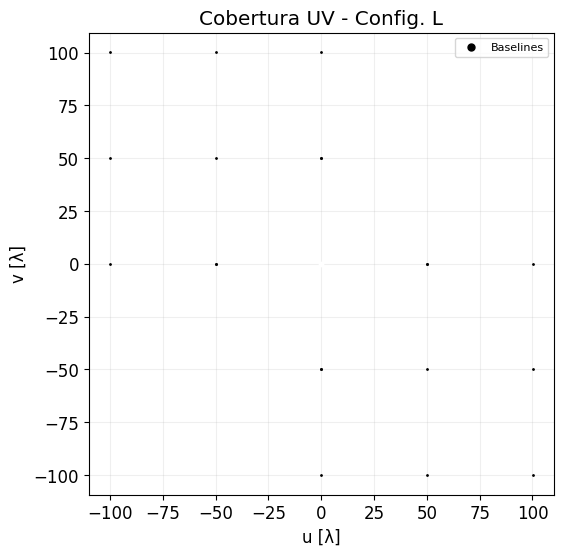

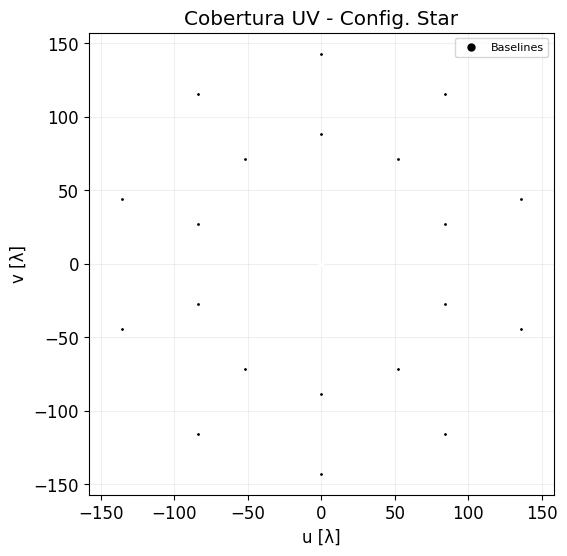


=== Pregunta 3.3 ===
resolución A: 1458.5124321745118 arcsec.
resolución B: 1445.864346390981 arcsec.


In [ ]:
# Su código aquí para Pregunta 3

# Configuración A: L
pos_A = np.array([[0, 0, 0],
                  [100, 0, 0],
                  [200, 0, 0],
                  [0, 100, 0],
                  [0, 200, 0]])

# Configuración B: Estrella de 5 puntas
angles = np.linspace(0, 2*np.pi, 5, endpoint=False)
pos_B = np.array([[150*np.cos(angle), 150*np.sin(angle), 0] for angle in angles])

# Funciones

def baselines(enu, include_conjugate=True):
    """
    Return all combination of baselines
    """
    enu = np.asarray(enu)
    N = len(enu)

    diff = enu[:, None, :] - enu[None, :, :]

    if include_conjugate:
        mask = ~np.eye(N, dtype=bool)
        baselines_result = diff[mask]
    else:
        i_indices, j_indices = np.triu_indices(N, k=1)
        baselines_result = diff[i_indices, j_indices]

    return baselines_result

def eq_to_uvw(H, delta, r_eq):
    """
    Obtains uvw array from XYZ from angle hours and delta.
    """
    cd, sd = np.cos(delta), np.sin(delta)
    ch, sh = np.cos(H), np.sin(H)

    R = np.array([
        [sh,      ch,     0],
        [-sd*ch,  sd*sh,  cd],
        [cd*ch,  -cd*sh,  sd]
    ])

    return np.einsum('ij,bj->bi', R, r_eq)

def uvw_to_lambda(uvw, freq_hz):
    """
    Converts uvw coordinates into wavelenghts from a given frequency.
    """
    c = 299792458.0  # light speed
    lam = c / freq_hz
    uvw_lambda = uvw / lam
    return uvw_lambda, lam

def plot_uv_coverage(
    uvw,
    unit="m",
    freq_hz=100e9,
    title=None,
    show_symmetry=True,
    show_center=True,
    center_color="white",
    center_size=50,
    color="deepskyblue",
    symmetry_color=None,
    cmap=None,
    color_by=None
):
    """
    Plot uvw coverage
    """
    # --- Selección de unidades ---
    if unit == "m":
        scale = 1.0
        label = "[m]"
    elif unit == "km":
        scale = 1e-3
        label = "[km]"
    elif unit.lower() in ["λ", "lambda", "wavelength"]:
        uvw, lam = uvw_to_lambda(uvw, freq_hz)
        scale = 1.0
        label = "[λ]"
    else:
        raise ValueError("Unidad no reconocida. Usa 'm', 'km' o 'lambda'.")

    u = uvw[..., 0] * scale
    v = uvw[..., 1] * scale

    if symmetry_color is None:
        if isinstance(color, str):
            symmetry_color = "royalblue" if color == "deepskyblue" else color
        else:
            symmetry_color = color

    plt.figure(figsize=(6, 6))

    if color_by is not None:
        sc = plt.scatter(u.flatten(), v.flatten(), c=color_by.flatten(),
                         s=2, cmap=cmap or "viridis", label="Baselines")
        plt.colorbar(sc, label="Color variable")
    else:
        plt.plot(u.flatten(), v.flatten(), "o", markersize=1, color=color, label="Baselines")

    if show_symmetry:
        plt.plot(-u.flatten(), -v.flatten(), "o", markersize=1,
                 alpha=0.4, color=symmetry_color, label="Simetría conjugada")

    # --- Punto central ---
    if show_center:
        plt.scatter(0, 0, color=center_color, s=center_size, zorder=5)

    plt.xlabel(f"u {label}")
    plt.ylabel(f"v {label}")
    plt.axis("equal")
    plt.grid(alpha=0.2)
    plt.legend(markerscale=5, fontsize=8, loc="upper right")

    if title:
        plt.title(title)
    else:
        plt.title(f"Cobertura UV ({unit})")

    plt.show()

def baseline_max_min(baselines):
    dist = pdist(baselines)
    return np.max(dist), np.min(dist)

def ang_res(freq, bmax, c):
    wavelength = c / freq
    res = wavelength / bmax
    res_arc = np.rad2deg(res) * 3600
    return res_arc

def enu_to_altaz(enu, rad=True, is_array=True):
  '''
  Transform the enu vector to altitude and azimut
  '''
  if is_array:
    E, N, U = enu[0], enu[1], enu[2]
  else:
    E, N, U = float(enu[0]), float(enu[1]), float(enu[2])

  r = np.hypot(E, N)
  El = np.arctan2(U, r)
  A = np.arctan2(E, N)

  if rad:
      return El, A % (2*np.pi)
  else:
      A_deg = np.degrees(A) % 360.0
      El_deg = np.degrees(El)
      return El_deg, A_deg

def hor_to_eq(enu, alt, az, phi=-33.45):
    """
    Transform ENU baseline into XYZ
    """
    phi = np.radians(phi)

    enu = np.asarray(enu)
    if enu.shape[-1] != 3:
        raise ValueError("El array ENU debe tener forma (..., 3)")

    E, N, U = enu[..., 0], enu[..., 1], enu[..., 2]

    b_norm = np.sqrt(E**2 + N**2 + U**2)

    X = b_norm * ( np.sin(alt)*np.cos(phi) - np.cos(alt)*np.sin(phi)*np.cos(az) )
    Y = b_norm * ( np.sin(az)*np.cos(alt) )
    Z = b_norm * ( np.sin(alt)*np.sin(phi) + np.cos(alt)*np.cos(phi)*np.cos(az) )

    return np.stack([X, Y, Z], axis=-1)

def eq_to_uvw_array(H_array, delta, r_eq):
    """
    Obtains uvw array from XYZ from a range of angle hours and static delta.
    """
    cd, sd = np.cos(delta), np.sin(delta)
    ch, sh = np.cos(H_array), np.sin(H_array)

    # Rotation matrix
    R = np.stack([
        np.stack([sh,        ch,        np.zeros_like(H_array)], axis=-1),
        np.stack([-sd*ch,    sd*sh,     np.full_like(H_array, cd)], axis=-1),
        np.stack([cd*ch,    -cd*sh,     np.full_like(H_array, sd)], axis=-1)
    ], axis=-2)

    uvw = np.einsum('hij,bj->bhi', R, r_eq)

    return uvw

# Parámetros de observación
freq = 150e6
c = 3e8
lat = -33.4375
lon = -70.65
H = 0
dec = np.deg2rad(lat)

# 3.1 Calcular baselines
print("\n=== Pregunta 3.1 ===")

baselines_result_A = baselines(pos_A, False)
baselines_result_B = baselines(pos_B, False)

baselines_result_A_conj = baselines(pos_A, True)
baselines_result_B_conj = baselines(pos_B, True)

print(f'Número de Baselines configuracion A: {len(baselines_result_A)}')
print(f'Número de Baselines configuracion B: {len(baselines_result_B)}')

altA, azA = enu_to_altaz(baselines_result_A_conj.T, rad=True)
reqA = hor_to_eq(baselines_result_A_conj, altA, azA)

altB, azB = enu_to_altaz(baselines_result_B_conj.T, rad=True)
reqB = hor_to_eq(baselines_result_B_conj, altB, azB)


# 3.2 Coordenadas uvw
print("\n=== Pregunta 3.2 ===")

# Cobertura
uvw_A = eq_to_uvw(0, dec, reqA)
uvw_B = eq_to_uvw(H, dec, reqB)

print("UVW_A: ",uvw_A.shape)
print("UVW_B: ",uvw_B.shape)
# Plot
plot_uv_coverage(uvw_A, unit='lambda', show_center=True, color='black', center_size=10, show_symmetry=False, freq_hz=freq, title="Cobertura UV - Config. L")
plot_uv_coverage(uvw_B, unit='lambda', show_center=True, color='black', center_size=10, show_symmetry=False, freq_hz=freq, title="Cobertura UV - Config. Star")

# 3.3 Análisis de cobertura uv
print("\n=== Pregunta 3.3 ===")

maxa, mina = baseline_max_min(pos_A)
maxb, minb = baseline_max_min(pos_B)

print(f"resolución A: {ang_res(freq, maxa, c)} arcsec.")
print(f"resolución B: {ang_res(freq, maxb, c)} arcsec.")

### Pregunta 3.1
Como se puede observar en el codigo, se obtienen los 10 pares de antenas (baselines) para cada configuración.

### Pregunta 3.2
Utilizando los datos entregados en el enunciado, fijando la latitud y longitud de Santiago de Chile, definiendo la Hora angulo 0. Podemos observar la cobertura uvw de cada una de las configuraciones en los gráficos correspondientes.

### Pregunta 3.3
Observando los resultados obtenidos para la resolucion angular de cada configuración, podemos notar que ninguna de estas permite observar una nebulosa a 30 arcsec. Por lo tanto este no es un factor decisivo para recomendar una configuración.

Sin embargo, si observamos los gráficos, podemos ver en la configuracion B, que esta presenta una covertura más uniforme y circular. Lo cual permite una mejor reconstrucción de imagen. Por tanto se podria recomendar la configuración de estrella para ver la nebulosa.


## Pregunta 4: Espacio de Fourier y Síntesis de Imágenes (1.5 puntos)

**Contexto:** Tienes una imagen interferométrica "sucia" de un cuásar con jets relativistas. Debes analizar y procesar la imagen para extraer información científica.

**4.1** (0.5 pts) Genere una imagen sintética de un cuásar con jets usando funciones matemáticas. Añada ruido y artefactos de interferometría. Aplique filtros para realzar los jets.

**4.2** (0.5 pts) Implemente un filtro pasa-altos y compárelo con filtros de detección de bordes (Sobel). ¿Cuál es más efectivo para detectar los jets?

**4.3** (0.5 pts) Analice la imagen en el espacio de Fourier. Identifique las frecuencias espaciales correspondientes a los jets y proponga una estrategia de reconstrucción usando algoritmos basados en gradiente.


=== Pregunta 4.1 ===


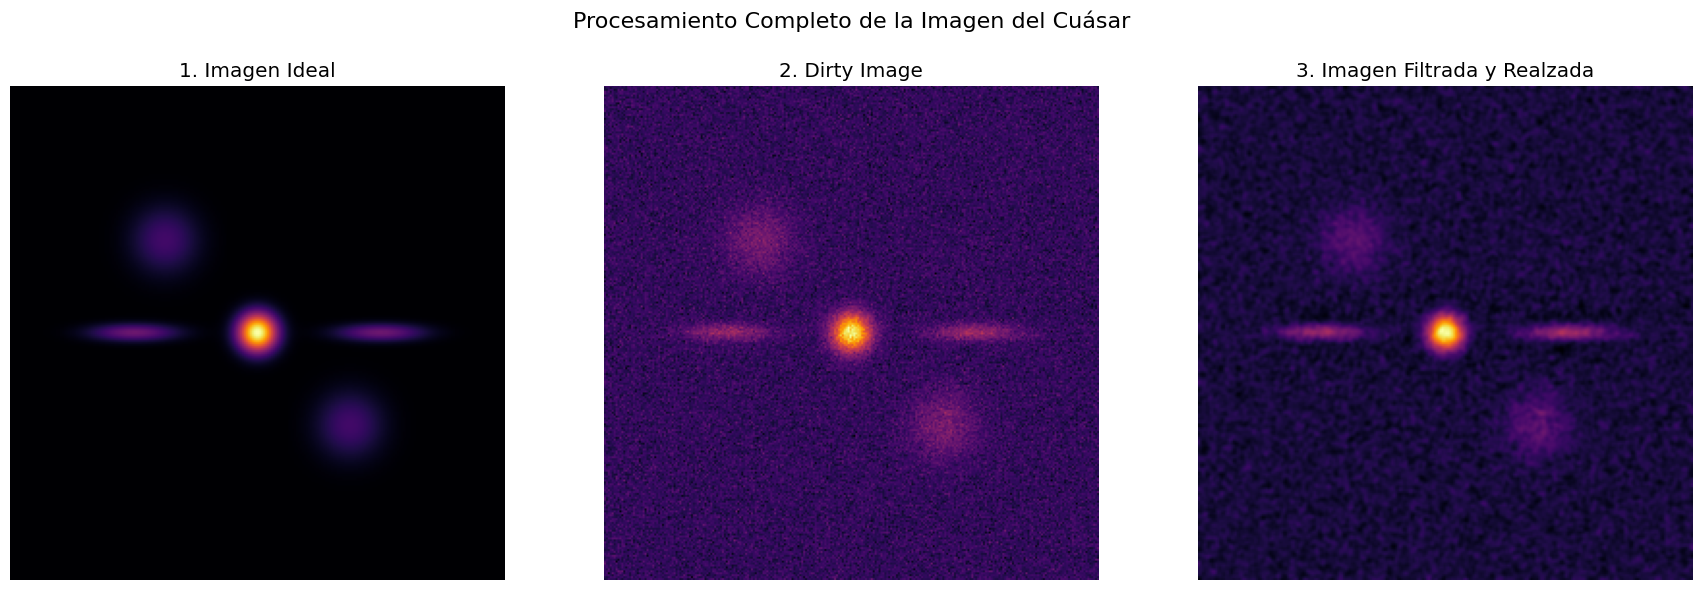


=== Pregunta 4.2 ===


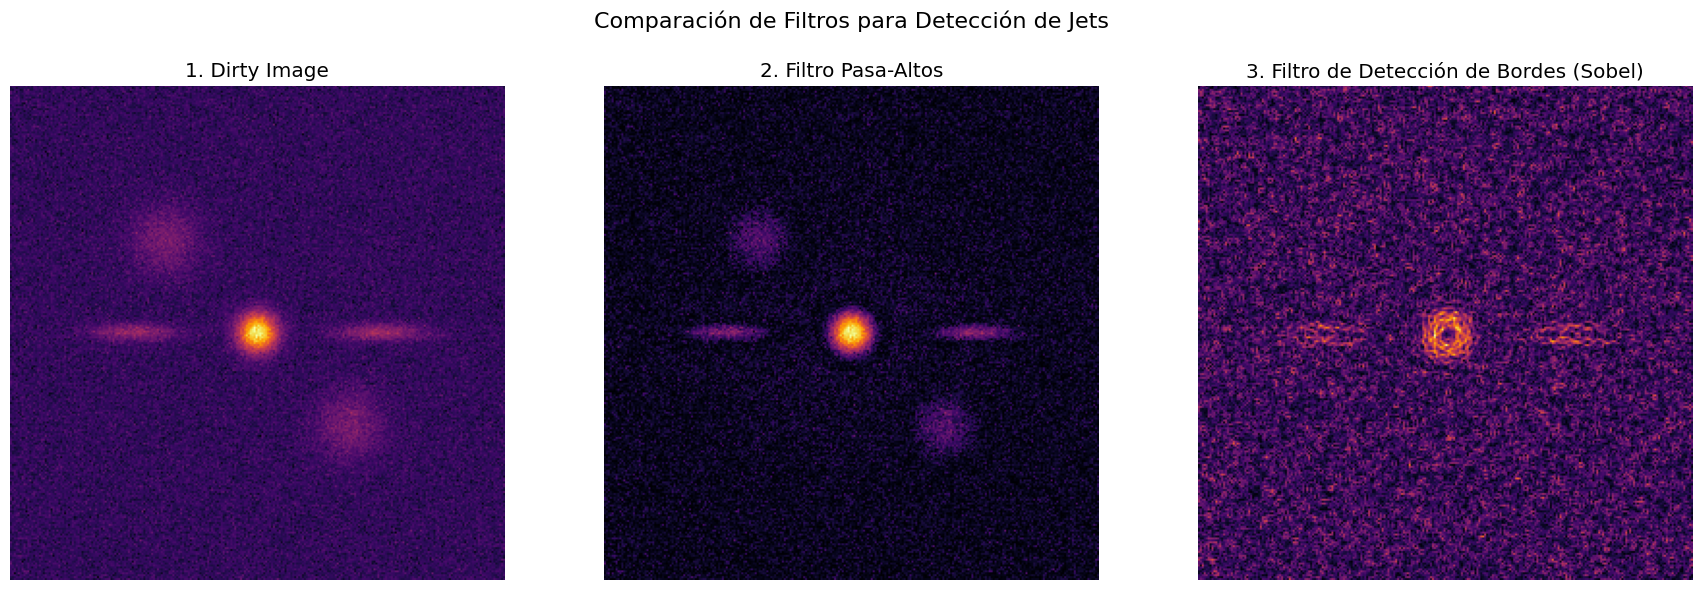


=== Pregunta 4.3 ===


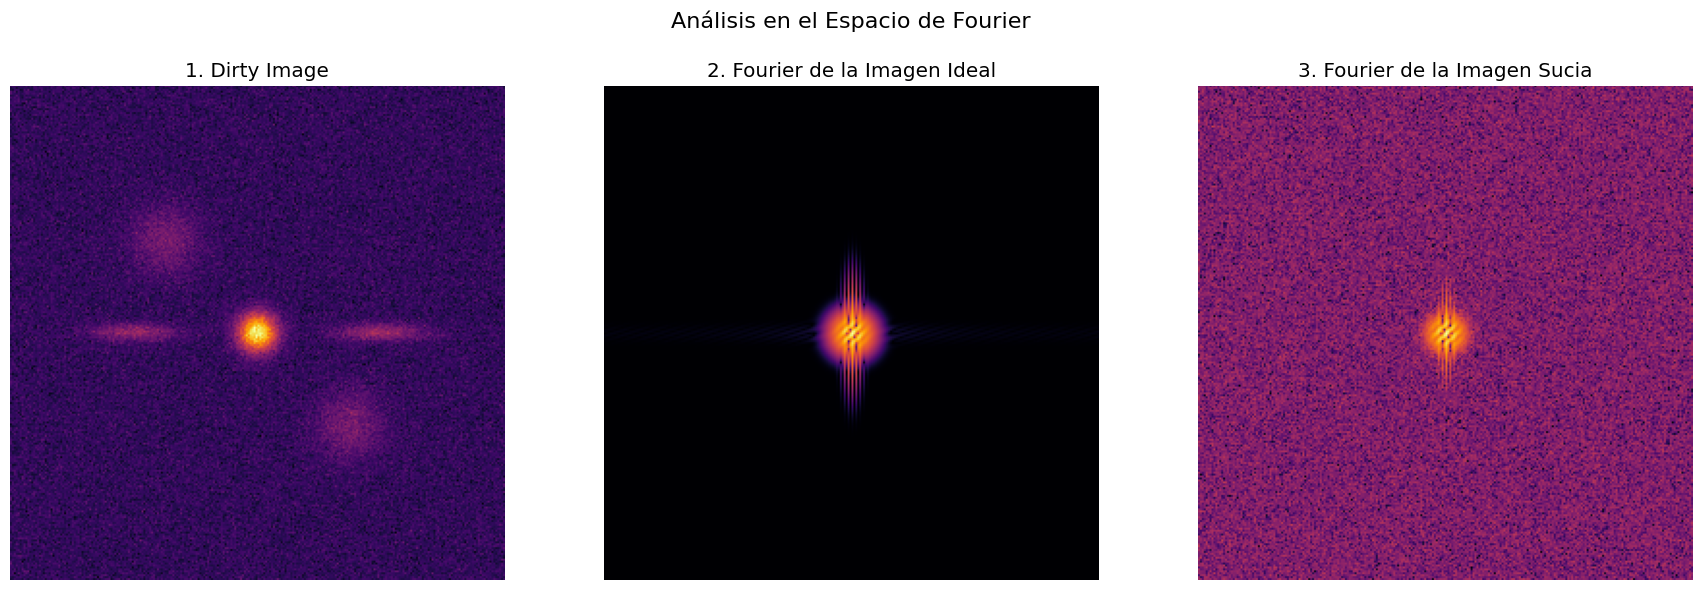

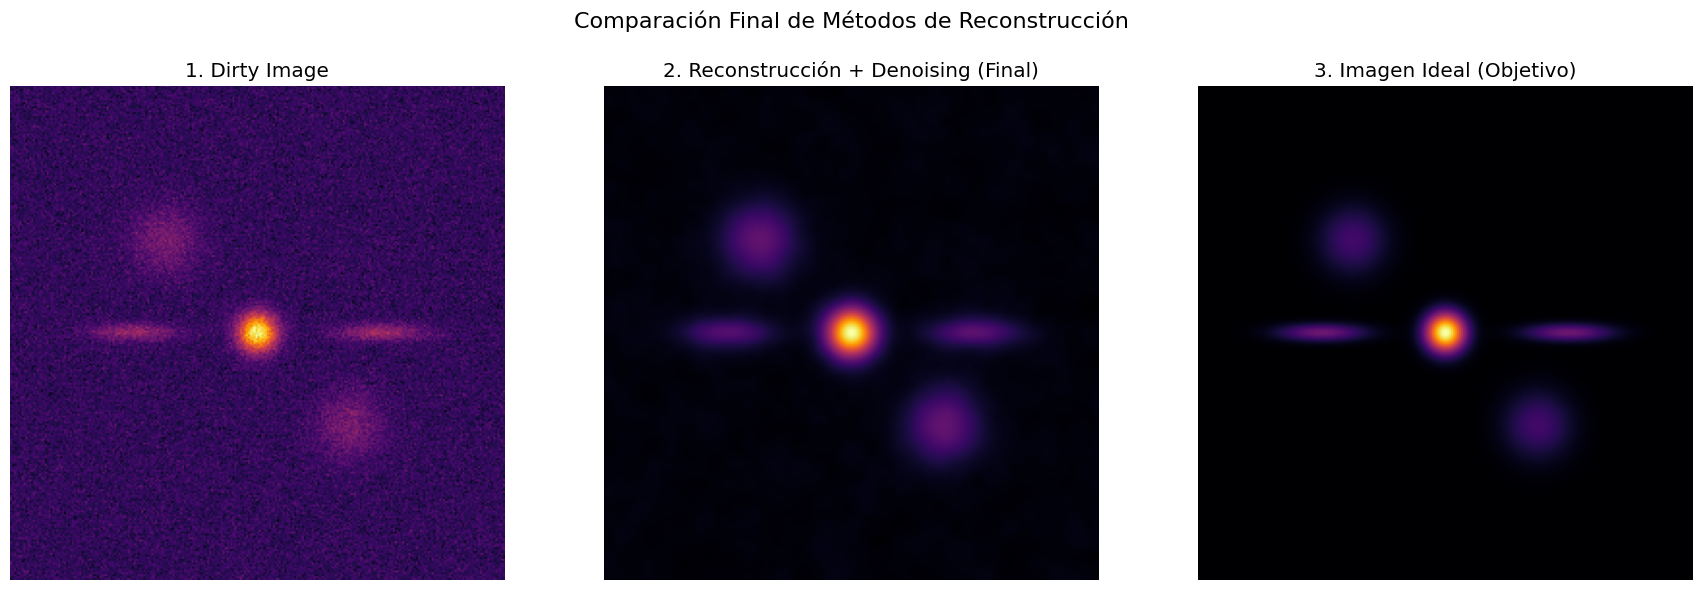

In [ ]:
# Su código aquí para Pregunta 4

# Funciones
def gaussian_noise(noise_level, shape):
    return np.random.normal(loc=0.0, scale=noise_level, size=shape)

def ghosting(img, noise_img):
    ghost = np.roll(img, shift=(-35, 50), axis=(0, 1))
    dirty_img = noise_img + 0.01 * ghost
    return dirty_img

def soft_and_highlight(dirty_img):
    soft_img = gaussian_filter(dirty_img, sigma=1.0)
    blurry_img = gaussian_filter(dirty_img, sigma=5.0)
    details = soft_img - blurry_img
    return soft_img + 1.5 * details

def plot_img(ideal_img, dirty_img, filtered_img):
    """
    Crea una visualización comparativa de las 3 etapas de la imagen.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle("Procesamiento Completo de la Imagen del Cuásar", fontsize=16)

    # Columna 1: Imagen Ideal
    axes[0].imshow(ideal_img, cmap='inferno')
    axes[0].set_title("1. Imagen Ideal")
    axes[0].axis('off')

    # Columna 2: Imagen Sucia (con ruido y artefactos)
    axes[1].imshow(dirty_img, cmap='inferno')
    axes[1].set_title("2. Dirty Image")
    axes[1].axis('off')

    # Columna 3: Imagen Filtrada
    axes[2].imshow(filtered_img, cmap='inferno')
    axes[2].set_title("3. Imagen Filtrada y Realzada")
    axes[2].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def get_mask(img, rc, filter):

  if img.ndim == 3:
        M, N, _ = img.shape
  else:
      M, N = img.shape

  U, V = np.ogrid[:M, :N]

  center_row, center_col = M // 2, N // 2

  distance = np.sqrt((U - center_row) ** 2 + (V - center_col) ** 2)

  mask = np.zeros((M, N))
  mask[distance <= rc] = 1

  if filter == "LOW":
    return mask
  else:
    return 1 - mask

def img_to_fourier(img):
  f2 = np.fft.ifftshift(img)
  f2 = np.fft.fft2(f2)
  f2_shifted = np.fft.fftshift(f2)

  return f2, f2_shifted

def fourier_to_image(f, shifted=True):
  if shifted:
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(f)))
  else:
    return np.fft.ifft2(np.fft.ifftshift(f))

def apply_filter(img, rc, filter, cmap="inferno"):

  f2, f2_shifted = img_to_fourier(img)
  mask = get_mask(img, rc, filter)

  filtered_img = f2_shifted * mask

  filtered_img = fourier_to_image(filtered_img)

  filtered_img = np.log1p(np.abs(filtered_img))

  return mask, filtered_img

def sobel(img):

  sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
  sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

  M, N = img.shape

  sobel_x_padded = np.zeros((M, N))
  sobel_y_padded = np.zeros((M, N))

  sobel_x_padded[:3, :3] = sobel_x
  sobel_y_padded[:3, :3] = sobel_y

  sobel_x_fourier = np.fft.fft2(sobel_x_padded)
  sobel_y_fourier = np.fft.fft2(sobel_y_padded)

  f2, f2_shifted = img_to_fourier(img)

  filtered_fourier_x = f2 * sobel_x_fourier
  filtered_fourier_y = f2 * sobel_y_fourier

  filtered_img_x = fourier_to_image(filtered_fourier_x)
  filtered_img_y = fourier_to_image(filtered_fourier_y)

  # Tomar solo la parte real
  filtered_img_x = np.real(filtered_img_x)
  filtered_img_y = np.real(filtered_img_y)

  # Calcular magnitud
  filtered_img = np.sqrt(filtered_img_x**2 + filtered_img_y**2)

  return filtered_img

def reconstruccion_con_denoising(imagen_sucia, n_iter=500, learning_rate=1.0, sigma_denoise=0.5):
    """
    Reconstruye y aplica un filtro de suavizado en cada iteración
    para eliminar tanto el ghosting como el ruido gaussiano.
    """
    shift = (-35, 50)
    shift_inverso = (35, -50)

    def forward_operator_A(img):
        ghost = np.roll(img, shift=shift, axis=(0, 1))
        return img + 0.01 * ghost

    def adjoint_operator_A_T(img):
        ghost_inverso = np.roll(img, shift=shift_inverso, axis=(0, 1))
        return img + 0.01 * ghost_inverso

    img_reconstruida = imagen_sucia.copy()

    for i in range(n_iter):

        residuo = forward_operator_A(img_reconstruida) - imagen_sucia
        gradiente = adjoint_operator_A_T(residuo)
        img_reconstruida -= learning_rate * gradiente

        img_reconstruida = gaussian_filter(img_reconstruida, sigma=sigma_denoise)
    return img_reconstruida

def plot(img, name1, img2, name2, img3, name3, title):

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(title, fontsize=16)

    axes[0].imshow(img, cmap='inferno')
    axes[0].set_title(name1)
    axes[0].axis('off')

    axes[1].imshow(img2, cmap='inferno')
    axes[1].set_title(name2)
    axes[1].axis('off')

    axes[2].imshow(img3, cmap='inferno')
    axes[2].set_title(name3)
    axes[2].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# 4.1 Generar imagen sintética de cuásar con jets
print("=== Pregunta 4.1 ===")

def crear_quasar_con_jets(size=256):
    """Crea una imagen sintética de cuásar con jets"""
    x = np.linspace(-4, 4, size)
    y = np.linspace(-4, 4, size)
    X, Y = np.meshgrid(x, y)

    # Núcleo del cuásar (punto central brillante)
    nucleo = np.exp(-(X**2 + Y**2)/0.1)

    # Jets (estructuras elongadas)
    # Jet principal (horizontal)
    jet1 = np.exp(-((X-2)**2)/0.5 - (Y**2)/0.02) * (X > 0)
    jet2 = np.exp(-((X+2)**2)/0.5 - (Y**2)/0.02) * (X < 0)

    # Jets secundarios (inclinados)
    jet3 = np.exp(-((X-1.5)**2 + (Y-1.5)**2)/0.3) * (X > 0.5)
    jet4 = np.exp(-((X+1.5)**2 + (Y+1.5)**2)/0.3) * (X < -0.5)

    quasar = nucleo + 0.3*jet1 + 0.3*jet2 + 0.2*jet3 + 0.2*jet4

    return quasar

# imagen ideal
ideal_img = crear_quasar_con_jets()
# ruido gaussiano
noise = gaussian_noise(0.05, ideal_img.shape)
noisy_img = ideal_img + noise
# dirty image -> imagen ideal + ruido + artefacto
dirty_img = ghosting(ideal_img, noisy_img)
# imagen suavizada y con jets realzados
filtered_img = soft_and_highlight(dirty_img)
# plot de imagenes
plot_img(ideal_img, dirty_img, filtered_img)

# 4.2 Comparación de filtros
print("\n=== Pregunta 4.2 ===")

_, high_pass_result = apply_filter(dirty_img, 1, 'HIGH')
sobel_result = sobel(dirty_img)

plot(dirty_img, "1. Dirty Image", high_pass_result, "2. Filtro Pasa-Altos", sobel_result, "3. Filtro de Detección de Bordes (Sobel)", "Comparación de Filtros para Detección de Jets")


# 4.3 Análisis en espacio de Fourier y algoritmos de gradiente
print("\n=== Pregunta 4.3 ===")

# Calcular las transformadas de Fourier
_, ideal_fourier = img_to_fourier(ideal_img)
_, dirty_fourier = img_to_fourier(dirty_img)

# Magnitud logarítmica para mejor visualización
ideal_fourier_magnitude = np.log1p(np.abs(ideal_fourier))
dirty_fourier_magnitude = np.log1p(np.abs(dirty_fourier))

plot(dirty_img, "1. Dirty Image", ideal_fourier_magnitude, "2. Fourier de la Imagen Ideal", dirty_fourier_magnitude, "3. Fourier de la Imagen Sucia", "Análisis en el Espacio de Fourier")

reconstructed_denoised_img = reconstruccion_con_denoising(
    dirty_img,
    n_iter=500,
    learning_rate=0.1,
    sigma_denoise=2
)

plot(dirty_img, "1. Dirty Image", reconstructed_denoised_img, "2. Reconstrucción + Denoising (Final)", ideal_img, "3. Imagen Ideal (Objetivo)", "Comparación Final de Métodos de Reconstrucción")

### Pregunta 4.1
Como se puede ver en la salida de la celda, para la pregunta 4.1 se presentan la imagen ideal, la dirty image (imagen ideal + ruido + artefactos) y la imágen suvizada utilizando un filtro gaussiano y un realce para los jets.

### Pregunta 4.2
Para esta pregunta se muestran los resultados de implementar un filtro pasa alta y aplicar sobel a la imagen, observando las imagenes podemos ver que el filtro pasa alta es el mas adecuado para obtener los jets, estos se ven de manera clara en la imagen y se distinguen del fondo. Puesto que al utilizar sobel, este resalta de manera excesiva el ruido del fondo y estos practicamente se confunden con el fondo.

### Pregunta 4.3
Finalmente, para la pregunta 4.3 se resuelven 2 preguntas:
1. Análisis de Fourier: En este gráfico (últimas 2 imagenes) podemos notar varias cosas. En primer lugar un gran punto en el centro, este representa el cuásar como tal de la imagen original, luego tenemos unas líneas verticales, estas corresponden a la representación de los jets. Además, podemos notar que al aplicar Fourier de la dirty image, esta mantiene cierto riudo en el fondo.

2. Reconstrucción por gradiente: Para esta tarea se aplico una técnica de gradiente, la cual en simples palabras limpia la dirty image, minimizando el error entre la imagen original y la solución a encontrar. El funcionamiento de este corresponde a:
    a. Punto de Partida: Empezamos con la imagen sucia como nuestra primera versión de la imagen "limpia".

    b. Simular y Comparar: En cada paso, tomamos nuestra imagen actual y le aplicamos el mismo artefacto (el ghost) que dañó la original. La diferencia entre ambas es el error.

    c. Calcular y Corregir: Usamos el error para calcular una dirección de corrección (el gradiente). Luego, modificamos nuestra imagen actual dando un pequeño paso en esa dirección para eliminar el ghost.

    d. Suavizar y Repetir: Finalmente, aplicamos un filtro de suavizado muy ligero para atenuar el ruido.

Se probó con diferentes parámetros para learning_rate y sigma_denoise y se optó por 0.1 y 2 respectivamente como mejor opción.

---

**¡Fin del examen!**

Recuerde guardar su trabajo y verificar que todas las preguntas estén respondidas.
